# Analysis template

In [1]:
!ls ../data

usnews2012.xlsx  usNewsData2012.txt  usNewsLinear.m


## Options to select

In [153]:
"""colleges=[]
asc_ranking_columns=['Overall Rank','Overall Score','Academic Reputation','Selectivity Rank',
                 'SAT (VM) 25-75th percentile','Percent freshmen top 10% HS Class',
                 'Acceptance','Faculty resource','Percent classes < 20 students',
                 'Percent classes >= 50 students','Student/Faculty ratio',
                 'Percent faculty full time','Graduation retention rank','Freshman retention',
                 'Financial resource rank','Alumni giving rank','Average Alumni giving rate']
desc_ranking_columns=['Overall Rank','Overall Score','Academic Reputation','Selectivity Rank',
                 'SAT (VM) 25-75th percentile','Percent freshmen top 10% HS Class',
                 'Acceptance','Faculty resource','Percent classes < 20 students',
                 'Percent classes >= 50 students','Student/Faculty ratio',
                 'Percent faculty full time','Graduation retention rank','Freshman retention',
                 'Financial resource rank','Alumni giving rank','Average Alumni giving rate']"""

problem="usNewsData2012"
ranking_columns=['Academic Reputation','Percent classes < 20 students','Freshman retention','Percent freshmen top 10% HS Class']

## Shouldn't need to edit below

In [154]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
import copy
import os

import pandas as pd
import numpy as np

from scipy.stats import pearsonr

from tqdm import tqdm
#import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib
import itertools
from pathlib import Path

from IPython.display import display, Markdown, Latex

In [156]:
home = str(Path.home())

In [157]:
import sys
sys.path.insert(0,"%s/rankability_toolbox_dev"%home)
import pyrankability

In [158]:
sys.path.insert(0,"%s/us_news_world_report_study"%home)
import base

In [159]:
year = base.read_instance(problem).set_index('College')
year

,Overall Rank,Overall Score,Academic Reputation,Selectivity Rank,SAT (VM) 25-75th percentile,Percent freshmen top 10% HS Class,Acceptance,Faculty resource,Percent classes < 20 students,Percent classes >= 50 students,Student/Faculty ratio,Percent faculty full time,Graduation retention rank,Freshman retention,Financial resource rank,Alumni giving rank,Average Alumni giving rate
College,,,,,,,,,,,,,,,,,
Williams,1,100,93,3,1420.0,90,19,3,71,3.0,7,96,1,97,6,3,58
Amherst,2,98,91,3,1440.0,87,15,5,73,3.0,8,94,1,98,9,2,57
Swarthmore,3,96,90,6,1435.0,84,16,5,77,2.0,8,93,4,97,9,14,46
Middlebury,5,93,86,6,1385.0,86,17,23,68,3.0,9,94,10,96,5,3,55
Pomona,4,94,87,1,1470.0,91,15,20,71,1.0,7,94,3,98,8,19,43
Bowdoin,6,92,87,9,1405.0,83,20,14,68,3.0,9,94,10,97,12,11,50
Wellesley,6,92,89,11,1375.0,78,34,14,64,1.0,8,93,14,95,6,16,46
Carleton,6,92,87,11,1400.0,76,31,12,65,1.0,9,97,4,97,25,1,58
Haverford,10,90,81,2,1395.0,94,26,7,77,0.3,8,95,10,96,13,16,44


## Converting to a D matrix
I expect we'll have some iterations and discussions on turning a year into a D matrix. Eventually, this code should be moved to base.py so everyone can share, but this is left for individual experimentation for now.

In [160]:
D = pd.DataFrame(index=year.index.copy(),columns=year.index.copy())
D.index.name = 'College1'
D.columns.name= 'College2'
for team1 in D.index:
    for team2 in D.columns:
        if team1 == team2:
            continue
        D.loc[team1,team2] = (year.loc[team1,ranking_columns] > year.loc[team2,ranking_columns]).sum()
D

College2,Williams,Amherst,Swarthmore,Middlebury,Pomona,Bowdoin,Wellesley,Carleton,Haverford,Claremont McKenna,...,Hamilton,Wesleyan,Colby,Colgate,Smith,Bates,Grinnell,Macalester,Bryn Mawr,Oberlin
College1,,,,,,,,,,,,,,,,,,,,,
Williams,NaN,2,2,4,1,3,4,3,2,3,...,3,4,4,4,4,4,4,4,3,3
Amherst,2,NaN,3,4,2,4,4,4,2,3,...,3,4,4,4,4,4,4,4,3,3
Swarthmore,1,1,NaN,3,2,3,4,3,2,2,...,4,4,4,4,4,4,4,4,4,4
Middlebury,0,0,1,NaN,0,1,3,2,1,2,...,3,3,4,4,3,3,3,4,3,3
Pomona,2,1,2,4,NaN,3,3,3,2,3,...,3,4,4,4,4,4,4,4,3,3
Bowdoin,0,0,0,2,0,NaN,3,2,2,2,...,3,4,4,4,3,3,3,4,3,3
Wellesley,0,0,0,1,1,1,NaN,2,1,1,...,2,2,2,4,3,3,3,3,3,3
Carleton,0,0,0,2,0,0,2,NaN,2,2,...,3,3,3,4,3,3,3,4,3,3
Haverford,2,2,1,2,2,2,3,2,NaN,1,...,4,2,3,3,3,3,3,3,3,3


## Rankability Analysis

In [161]:
delta_lop,details_lop = pyrankability.rank.solve(D,method='lop',cont=False)
delta_hillside,details_hillside = pyrankability.rank.solve(D,method='hillside',cont=False)

/home/jupyter-pander14/rankability_toolbox_dev/pyrankability/construct.py:81: RuntimeWarning: invalid value encountered in greater
  mask1 = np.abs(S[:,j]-S[:,i])>threshold # smooth things out and don't worry about warnings here
/home/jupyter-pander14/rankability_toolbox_dev/pyrankability/construct.py:82: RuntimeWarning: invalid value encountered in greater
  mask2 = np.abs(S[j,:]-S[i,:])>threshold # smooth things out and don't worry about warnings here


### Distance to perfection

In [162]:
delta_lop

237

In [163]:
delta_hillside

766

**Objective value for LOP (upper triangular reordered sum)**

In [164]:
details_lop['obj']

871.0

### X*

In [165]:
delta_cont = {}
details_cont = {}
delta_cont['lop'],details_cont['lop'] = pyrankability.rank.solve(D,method='lop',cont=True)
delta_cont['hillside'],details_cont['hillside'] = pyrankability.rank.solve(D,method='hillside',cont=True)

In [166]:
label = "A"
xstars = {}
indices = {}
for method in delta_cont.keys():
    details = details_cont[method]
    xstar = pd.DataFrame(details['x'],index=D.index,columns=D.columns)
    xstars["%s. %s"%(label,method)] = xstar
    indices["%s. %s"%(label,method)] = details['indices']
    label = chr(ord(label)+1)
g,score_df,ordered_xstars = pyrankability.plot.show_score_xstar2(xstars,
                                                                 group_label="Group",width=300,height=300,
                                                                 columns=2,resolve_scale=True)
g

alt.FacetChart(...)

## Find pair in P with maximum number of discordant pairs

In [167]:
_,pair_max_tau_details = pyrankability.search.solve_pair_max_tau(D,method='lop',verbose=False,lazy=False)

**Tau**

In [169]:
pair_max_tau_details['tau']

0.7533333333333333

**Number of discorand pairs**

In [170]:
pair_max_tau_details['obj']

37.0

**Visual**

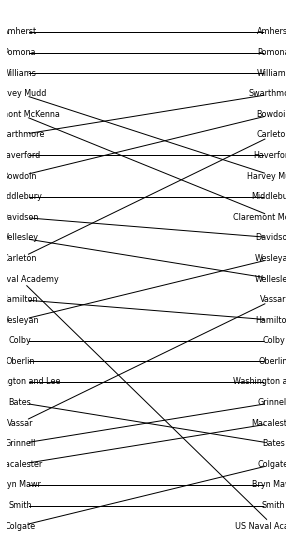

In [171]:
perm_x = np.array(pair_max_tau_details['perm_x'])
perm_y = np.array(pair_max_tau_details['perm_y'])
AB = pyrankability.plot.AB_to_P2(perm_x,perm_y)
AB_colleges = AB.copy()
for ix in AB_colleges.index:
    for c in AB_colleges.columns:
        v = AB_colleges.loc[ix,c]
        v = D.index[v]
        AB_colleges.loc[ix,c] = v
pyrankability.plot.spider(AB_colleges,file="visual1.png")

### Finding pairs within a tau range

See if there are any two solutions that are within a decent range of each other

In [172]:
tau_range=(0.8,0.9)
_,pair_tau_range_details = pyrankability.search.solve_pair_tau_range(tau_range,D,method='lop',verbose=False,lazy=False)
pair_tau_range_details['tau']

0.8866666666666667

In [185]:
tau_range=(-.2,0.2)
_,pair_tau_range_details = pyrankability.search.solve_pair_tau_range(tau_range,D,method='lop',verbose=False,lazy=False)
pair_tau_range_details['tau']

0.1282051282051282

Now see if there are any two solutions that are far away from each other

In [181]:
tau_range=(-0.1,0.1)
_,pair_tau_range_details = pyrankability.search.solve_pair_tau_range(tau_range,D,method='lop',verbose=False,lazy=False)
pair_tau_range_details['tau']

AttributeError: Unable to retrieve attribute 'X'

**Example about how to examine a pair**

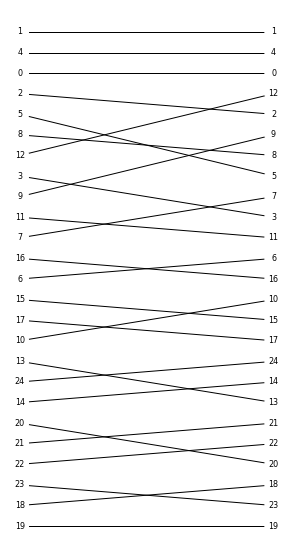

In [173]:
perm_x = np.array(pair_tau_range_details['perm_x'])
perm_y = np.array(pair_tau_range_details['perm_y'])
pyrankability.plot.spider(pyrankability.plot.AB_to_P2(perm_x,perm_y))

Now what happens when you can't find a pair within the range

In [99]:
tau_range=(-0.001,0.001)
_,pair_tau_range_details = pyrankability.search.solve_pair_tau_range(tau_range,D,method='lop',verbose=False,lazy=False)

AttributeError: Unable to retrieve attribute 'X'

## Collect all solutions

In [174]:
delta_lop_with_models,details_lop_with_models = pyrankability.rank.solve(D,method='lop',cont=False,include_model=True)
delta_hillside_with_models,details_hillside_with_models = pyrankability.rank.solve(D,method='hillside',cont=False,include_model=True)

/home/jupyter-pander14/rankability_toolbox_dev/pyrankability/construct.py:81: RuntimeWarning: invalid value encountered in greater
  mask1 = np.abs(S[:,j]-S[:,i])>threshold # smooth things out and don't worry about warnings here
/home/jupyter-pander14/rankability_toolbox_dev/pyrankability/construct.py:82: RuntimeWarning: invalid value encountered in greater
  mask2 = np.abs(S[j,:]-S[i,:])>threshold # smooth things out and don't worry about warnings here


### LOP

In [175]:
model = details_lop_with_models['model']
model_file = pyrankability.common.write_model(model)
solution_file = model_file + ".solutions"
model_file

'/tmp/tmp0zizdjxp/model.mps'

In [176]:
!sed -i '/^OBJSENS/d' $model_file

In [177]:
!head $model_file

NAME lop
ROWS
 N  OBJ
 L  R0      
 G  R1      
 L  R2      
 G  R3      
 L  R4      
 G  R5      
 L  R6      


In [ ]:
%%timeit
%%bash -s "$model_file" "$solution_file"
~/rankability_toolbox_dev/collect.sh $1 $2

Model file: /tmp/tmp0zizdjxp/model.mps
Solutions file: /tmp/tmp0zizdjxp/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp0zizdjxp/model.mps
Solutions file: /tmp/tmp0zizdjxp/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp0zizdjxp/model.mps
Solutions file: /tmp/tmp0zizdjxp/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp0zizdjxp/model.mps
Solutions file: /tmp/tmp0zizdjxp/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp0zizdjxp/model.mps
Solutions file: /tmp/tmp0zizdjxp/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp0zizdjxp/model.mps
Solutions file: /tmp/tmp0zizdjxp/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

In [136]:
opt_k = details_lop_with_models['obj']

solutions = pd.read_csv(solution_file,sep=', ')
x_columns = solutions.columns[1:-1]
xs = []
a,b,c = 1,1,-2*len(x_columns)
n = int((-b + np.sqrt(b**2 - 4*a*c))/(2*a) + 1)
xstar = np.zeros((n,n))
objs = []
s = 0
for k in range(solutions.shape[0]):
    x = np.zeros((n,n))
    for c in x_columns:
        ij_str = c.replace("x(","").replace(")","")
        i,j = ij_str.split(",")
        i,j = int(i),int(j)
        x[i,j] = solutions.loc[k,c]
        x[j,i] = 1 - x[i,j]
    obj = np.sum(np.sum(D*x))
    xs.append(x)
    objs.append(obj)
    error = obj - opt_k
    xstar += x
xstar = xstar/solutions.shape[0]
pd.DataFrame(xstar)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,0.833333,0.666667,0.000000,0.5,1.0,0.00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.00,1.0,1.0,1.0
1,0.166667,0.000000,0.000000,0.000000,0.0,1.0,0.00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.00,1.0,1.0,1.0
2,0.333333,1.000000,0.000000,0.333333,0.0,1.0,0.00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.00,1.0,1.0,1.0
3,1.000000,1.000000,0.666667,0.000000,0.5,1.0,0.00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.00,1.0,1.0,1.0
4,0.500000,1.000000,1.000000,0.500000,0.0,1.0,0.00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.00,1.0,1.0,1.0
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.00,1.0,0.0,1.0
6,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.50,1.0,1.0,1.0
7,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.00,1.0,0.0,1.0
8,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.00,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.00,1.0,1.0,1.0
9,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.00,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.00,1.0,0.0,1.0


In [137]:
objs

[2689.0,
 2689.0,
 2689.0,
 2689.0,
 2689.0,
 2689.0,
 2689.0,
 2689.0,
 2689.0,
 2689.0,
 2689.0,
 2689.0]

In [138]:
opt_k

2689.0

### Hillside

In [139]:
model = details_hillside_with_models['model']
model_file = pyrankability.common.write_model(model)
solution_file = model_file + ".solutions"
model_file

'/tmp/tmp6s18t8mj/model.mps'

In [140]:
!sed -i '/^OBJSENS/d' $model_file

In [141]:
%%timeit
%%bash -s "$model_file" "$solution_file"
~/rankability_toolbox_dev/collect.sh $1 $2

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmp6s18t8mj/model.mps
Solutions file: /tmp/tmp6s18t8mj/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

81.2 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [149]:
opt_k = details_hillside_with_models['obj']
C = details_hillside_with_models['c']
solutions = pd.read_csv(solution_file,sep=', ')
x_columns = solutions.columns[1:-1]
xs = []
a,b,c = 1,1,-2*len(x_columns)
n = int((-b + np.sqrt(b**2 - 4*a*c))/(2*a) + 1)
xstar = np.zeros((n,n))
objs = []
s = 0
for k in range(solutions.shape[0]):
    x = np.zeros((n,n))
    for c in x_columns:
        ij_str = c.replace("x(","").replace(")","")
        i,j = ij_str.split(",")
        i,j = int(i),int(j)
        x[i,j] = solutions.loc[k,c]
        x[j,i] = 1 - x[i,j]
    obj = np.sum(np.sum(C*x))
    xs.append(x)
    objs.append(obj)
    error = obj - opt_k
    xstar += x
xstar = xstar/solutions.shape[0]
pd.DataFrame(xstar)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,0.0,0.5,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.5,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.5,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [151]:
opt_k

2373.0

In [152]:
objs

[2373.0, 2373.0]